# Generative Addversarial Networks (GANs): Deep Convolutional GANs (DCGANs)

Deep Convolutional GANs use convolutional layers instead of Dense of fully connected ones.
Convolutional layers are better suited for images.
DCGANs alleviate the mode collapse error.

This notebook replicates the content in the previous, but the GAN models are built using convolutional layers; thus, look at the previous notebook if more detailed commentes are required.

Major changes:
- Images are scaled differently to be used with `tanh`
- The model is different: convlutions are used, batch normalization, leaky ReLU (which seems to work better for GANs), etc.
- The number of epochs should be larger; e.g., 20
- We should try GPUs, otherwise the training is going to last a long time... Alternative: Google Colab

## Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.datasets import mnist

In [5]:
(X_train,y_train), (X_test,y_test) = mnist.load_data()

### Reshape & Scale Images

The Generator uses `tanh` as activation function, which generates values in `[-1,1]`. Therefore, the image/pixel values need to be adjusted.

In [10]:
X_train.max()

1.0

In [11]:
X_train.shape

(60000, 28, 28, 1)

In [8]:
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

In [9]:
X_train = X_train.reshape(-1,28,28,1)*2.0 - 1.0

In [16]:
X_train.shape

(60000, 28, 28, 1)

In [17]:
X_test = X_test.reshape(-1,28,28,1)*2.0 - 1.0

### Filter Data for a Smaller Dataset

In [18]:
# We take only images with 0 numbers to make it easier and faster - the goal is to learn
# Also, the number 0 is quite distinct
# However, we could choose any number
number = 0
only_zeros = X_train[y_train==number]

## Model

In [26]:
import tensorflow as tf
# Leaky ReLU seems to work better with DCGANs
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

In [41]:
coding_size = 100

In [24]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

In [25]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [28]:
GAN = Sequential([generator, discriminator])

In [29]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [30]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [31]:
GAN.layers[0].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
______________________________________________

In [32]:
GAN.layers[1].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6273      
Total params: 425,730
Trainable params: 212,865
Non-trainable params: 212,865
__________________________________________

## Training Batches

In [33]:
import tensorflow as tf

In [34]:
batch_size = 32

In [35]:
# my_data = X_train
my_data = only_zeros

In [36]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [37]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## Training Loop

In [51]:
# It presumably works better with more epochs, e.g., 20
epochs = 5

In [44]:
# Unpack the GAN models
generator, discriminator = GAN.layers

In [45]:
for epoch in range(epochs):
    print(f"Currently in Epoch {epoch+1}")
    # Batch counter/tracker
    i = 0
    for X_batch in dataset:
        # Batch counter
        i = i + 1
        if i%50 == 0:
            print(f"\tCurrently in Batch {i} of {len(my_data)//batch_size}")
            
        # Phase 1: DISCRIMINATOR TRAINING
        # We create the latent noise vector: batch x latent space
        noise = tf.random.normal(shape=[batch_size,coding_size])
        # Feed the Generator with the noise vector to generate images
        gen_images = generator(noise)
        # Conocatenate fake & real images
        # We need to cast our real images
        X_fake_vs_real = tf.concat([gen_images,tf.dtypes.cast(X_batch,tf.float32)],axis=0)
        # Set target label
        # We expand lists of 0.0 and 1.0 elements and concatenate them
        # We do that regardless on how many classes we have!
        y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)
        # We make the Discriminator trainable
        # It was not trainable in order to compile the GAN above
        discriminator.trainable = True
        # Train one batch
        discriminator.train_on_batch(X_fake_vs_real,y1)
        
        # Phase 2: GENERATOR TRAINING
        # Create latent noise, as before
        noise = tf.random.normal(shape=[batch_size,coding_size])
        # We create FAKE images, but LABEL THEM AS REAL
        y2 = tf.constant([[1.0]]*batch_size)
        # Switch off Dirscriminator training
        discriminator.trainable = False
        # Train complete GAN on the batch:
        # noise fed to Generator -> 
        # output to Discriminator ->
        # custom ground truth (real but fake) used to compute loss
        GAN.train_on_batch(noise,y2)

print("Training Complete!")

Currently in Epoch 1
	Currently in Batch 50 of 185
	Currently in Batch 100 of 185
	Currently in Batch 150 of 185
Currently in Epoch 2
	Currently in Batch 50 of 185
	Currently in Batch 100 of 185
	Currently in Batch 150 of 185
Currently in Epoch 3
	Currently in Batch 50 of 185
	Currently in Batch 100 of 185
	Currently in Batch 150 of 185
Currently in Epoch 4
	Currently in Batch 50 of 185
	Currently in Batch 100 of 185
	Currently in Batch 150 of 185
Currently in Epoch 5
	Currently in Batch 50 of 185
	Currently in Batch 100 of 185
	Currently in Batch 150 of 185
Training Complete!


## Inference

In [48]:
# Noise vectors
noise = tf.random.normal(shape=[10, codings_size])

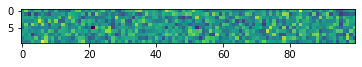

In [49]:
plt.imshow(noise)

In [47]:
images = generator(noise)

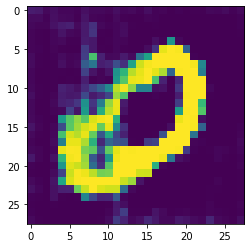

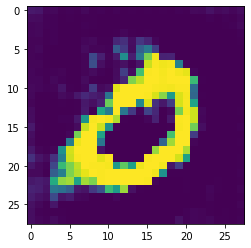

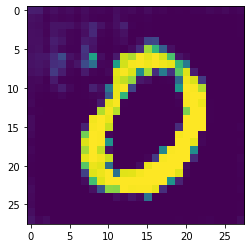

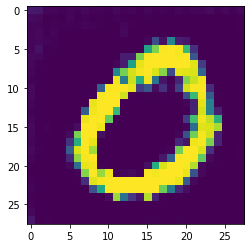

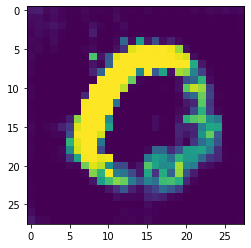

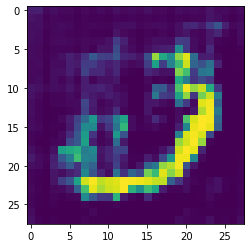

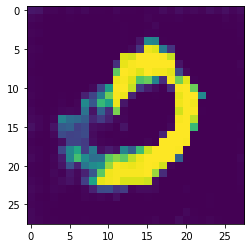

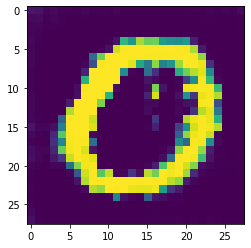

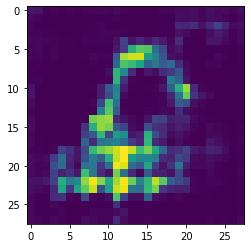

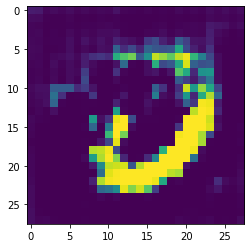

In [50]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()